# Classification with FNO
Train an FNO timeseries classifier on the FordA dataset from the UCR/UEA archive.

Much of this comes from the following Keras tutorial: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

The dataset we are using here is called FordA. The data comes from the UCR archive. The dataset contains 3601 training instances and another 1320 testing instances. Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. For this task, the goal is to automatically detect the presence of a specific issue with the engine. The problem is a balanced binary classification task. The full description of this dataset can be found here: http://www.j-wichard.de/publications/FordPaper.pdf

Later, can include the features mentioned in the paper; namely the autocorrelation values and spectral density features as separate channels, akin to the work we will do later

In [6]:
import importlib
import model_utils
import data_utils
importlib.reload(model_utils)
importlib.reload(data_utils)
from model_utils import FNOClassifier
from data_utils import CustomDataset, RandomSample, RandomTimeTranslateFill05, RandomTimeTranslateReflect, RandomNoise

import os
import optuna
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms

import pytorch_lightning as pl
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
pl.__version__

'2.1.3'

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available on device {torch.cuda.get_device_name(0)} with device count: {torch.cuda.device_count()}")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available on device NVIDIA GeForce RTX 2080 Ti with device count: 1


## Load the data

Ford dataset

In [3]:
# # Read the data
# def readucr(filename):
#     data = np.loadtxt(filename, delimiter="\t")
#     y = data[:, 0]
#     x = data[:, 1:]
#     return x, y.astype(int)

# root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

# x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
# x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

# # Reshape the data to be ready for multivariate time-series data (multiple channels)
# # Shape is (samples, channels, sequence length)
# x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
# x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
# print("x_train shape: ", x_train.shape)
# print("x_test shape: ", x_test.shape)

# # Standardize the labels to positive integers. The expected labels will then be 0 and 1.
# y_train[y_train == -1] = 0
# y_test[y_test == -1] = 0

# # Canonicalize the data (pass through 0 at the origin)
# x_train -= x_train[:, :, 0].reshape(-1, 1, 1)
# x_test -= x_test[:, :, 0].reshape(-1, 1, 1)

# # Scale the data to be between 0 and 1
# min_val = np.min(x_train)
# max_val = np.max(x_train)
# x_train = ((x_train - min_val) / (max_val - min_val))
# x_test = ((x_test - min_val) / (max_val - min_val))

# # Convert to numpy arrays
# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_test = np.array(x_test)
# y_test = np.array(y_test)

# # Create a list of indices for your dataset
# indices = list(range(len(x_test)))
# np.random.shuffle(indices)

# # Split the indices into two parts: train and val
# val_size = int(0.5 * len(x_test))
# val_indices, test_indices = np.array(indices[:val_size]), np.array(indices[val_size:])

# # Create datasets
# train_x = torch.tensor(x_train, dtype=torch.float32)
# train_y = torch.tensor(y_train, dtype=torch.float32)
# valid_x = torch.tensor(x_test[val_indices], dtype=torch.float32)
# valid_y = torch.tensor(y_test[val_indices], dtype=torch.float32)
# test_x = torch.tensor(x_test[test_indices], dtype=torch.float32)
# test_y = torch.tensor(y_test[test_indices], dtype=torch.float32)

# # Print ratio of classes in train, valid, and test
# print("Train dataset shape and ratio (# 0/total): ", train_x.shape, torch.unique(train_y, return_counts=True)[1][0]/train_y.shape[0])
# print("Valid dataset shape and ratio (# 0/total): ", valid_x.shape, torch.unique(valid_y, return_counts=True)[1][0]/valid_y.shape[0])
# print("Test dataset shape and ratio (# 0/total): ", test_x.shape, torch.unique(test_y, return_counts=True)[1][0]/test_y.shape[0])

In [7]:
# Kepler Lightcurve dataset
directory = "../../kepler_lightcurve_data/"

# Load KeplerLightCurves.csv
data = np.genfromtxt(directory + "KeplerLightCurves.csv", delimiter=',')
X = data[:, :-1]
y = data[:, -1]

# Reshape the data to be ready for multivariate time-series data (multiple channels)
# Shape is (samples, channels, sequence length)
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("X shape: ", X.shape)

# Prepare labels
y = y - 1 # Shift the labels to start from 0
print("y shape and values: ", y.shape, np.unique(y))

# Canonicalize the data (pass through 0 at the origin)
X -= X[:, :, 0].reshape(-1, 1, 1)

# Create a list of indices for your dataset
indices = list(range(len(X)))
np.random.seed(0)
np.random.shuffle(indices)

# Split the indices into train, val, and test
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
train_indices, val_indices, test_indices = np.array(indices[:train_size]), np.array(indices[train_size:train_size+val_size]), np.array(indices[train_size+val_size:])

# Scale the data to be between 0 and 1
x_train = X[train_indices]
min_val = np.min(x_train)
max_val = np.max(x_train)
X = (X - min_val) / (max_val - min_val)

# Create datasets
train_x = torch.tensor(X[train_indices], dtype=torch.float32)
train_y = torch.tensor(y[train_indices], dtype=torch.long)
valid_x = torch.tensor(X[val_indices], dtype=torch.float32)
valid_y = torch.tensor(y[val_indices], dtype=torch.long)
test_x = torch.tensor(X[test_indices], dtype=torch.float32)
test_y = torch.tensor(y[test_indices], dtype=torch.long)

# Print shape of train, valid, and test datasets
print("Train dataset shape: ", train_x.shape)
print("Valid dataset shape: ", valid_x.shape)
print("Test dataset shape: ", test_x.shape)

X shape:  (1319, 1, 4767)
y shape and values:  (1319,) [0. 1. 2. 3. 4. 5. 6.]
Train dataset shape:  torch.Size([923, 1, 4767])
Valid dataset shape:  torch.Size([263, 1, 4767])
Test dataset shape:  torch.Size([133, 1, 4767])


In [8]:
# Create train, valid, and test data loaders
batch_size = 16 # too large of a batchsize crashes the kernel (memory issues due to fft and irfft)
workers = 0
data_augmentation = None

if data_augmentation == "randomsample":
        n_sample = 400
        seq_length = n_sample
        train_loader = DataLoader(
                CustomDataset(
                        train_x, 
                        train_y, 
                        transform=transforms.RandomApply([RandomSample(n_sample=n_sample)], p=1) # Can't be used with other transforms as it changes the shape of the data
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomnoise":
        seq_length = train_x.shape[2]
        train_loader = DataLoader(
                CustomDataset(
                        train_x, 
                        train_y, 
                        transform=transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomtimetranslatefill05":
        seq_length = train_x.shape[2]
        train_loader = DataLoader(
                CustomDataset(
                        train_x, 
                        train_y, 
                        transform=transforms.RandomApply([RandomTimeTranslateFill05(max_shift=100)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomtimetranslatereflect":
        seq_length = train_x.shape[2]
        train_loader = DataLoader(
                CustomDataset(
                        train_x, 
                        train_y, 
                        transform=transforms.RandomApply([RandomTimeTranslateReflect(max_shift=100)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomnoise_randomtimetranslatefill0":
        seq_length = train_x.shape[2]
        train_loader = DataLoader(
                CustomDataset(
                        train_x, 
                        train_y, 
                        transform=transforms.Compose([
                                transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.5),
                                transforms.RandomApply([RandomTimeTranslateFill05(max_shift=100)], p=0.5),
                        ])
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )   

elif data_augmentation == "randomnoise_randomtimetranslatereflect":
        seq_length = train_x.shape[2]
        train_loader = DataLoader(
                CustomDataset(
                        train_x, 
                        train_y, 
                        transform=transforms.Compose([
                                transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.5),
                                transforms.RandomApply([RandomTimeTranslateReflect(max_shift=100)], p=0.5),
                        ])
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )    

else:
        seq_length = train_x.shape[2]
        train_loader = DataLoader(
                CustomDataset(
                        train_x, 
                        train_y, 
                        transform=None
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers, 
        )  

valid_loader = DataLoader(
        CustomDataset(
                valid_x, 
                valid_y
        ),
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
        num_workers=workers,
)

test_loader = DataLoader(
        CustomDataset(
                test_x, 
                test_y
        ),
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
        num_workers=workers,
)

# Print the size of a batch and type of data
for x, y in train_loader:
    print("train loader")
    print("Sample batch of data (batch size, # channels, sequence length): " + str(x.shape))
    print("Sample batch of labels: " + str(y.shape))
    break

# Check validation loader too
for x, y in valid_loader:
    print("valid loader")
    print("Sample batch of data (batch size, # channels, sequence length): " + str(x.shape))
    print("Sample batch of labels: " + str(y.shape))
    break

train loader
Sample batch of data (batch size, # channels, sequence length): torch.Size([16, 1, 4767])
Sample batch of labels: torch.Size([16])
valid loader
Sample batch of data (batch size, # channels, sequence length): torch.Size([16, 1, 4767])
Sample batch of labels: torch.Size([16])


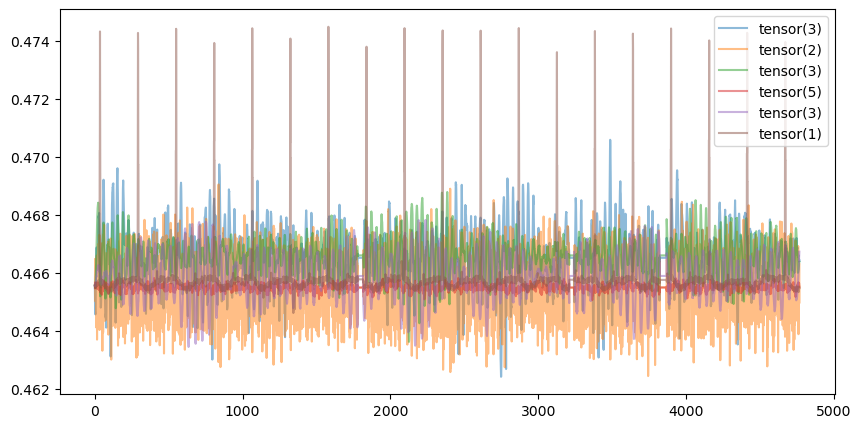

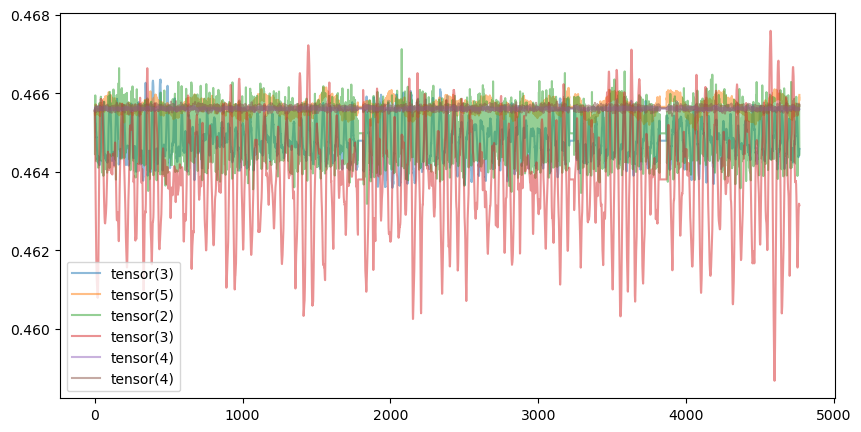

In [9]:
# Plot a few signals from valid_loader and labels for each class
plt.figure(figsize=(10, 5))
for i, (x, y) in enumerate(train_loader):
    if i == 1:
        break

    for j in range(6):
        plt.plot(x[j, 0, :], label=y[j], alpha=0.5)
    plt.legend()
plt.show()

# Plot a few signals from valid_loader and labels for each class
plt.figure(figsize=(10, 5))
for i, (x, y) in enumerate(valid_loader):
    if i == 1:
        break

    for j in range(6):
        plt.plot(x[j, 0, :], label=y[j], alpha=0.5)
    plt.legend()
plt.show()

## Train and test a model

In [20]:
# Hyperparameters
modes = 25
channels = [1024, 1024] 
pool_type = "avg" 
pooling = seq_length # Remember to change this if using RandomSample augmentation
proj_dim = 2 # Dimension to project to initially
p_dropout = 0.5
add_noise = False
num_classes = 7
fc_post_pooling = True

# Optimizers and learning rate schedulers
# lr schedule options are reducelronplateau, steplr, exponentiallr, cosineannealinglr, and cosineannealingwarmrestarts
# optimizer options are sgd or adam
optimizer = "sgd"
momentum = 0.9 # Only used for SGD optimizer
scheduler = "reducelronplateau"
lr = 3e-2

# Initialize classifier
classifier = FNOClassifier(
                modes=modes, 
                lr=lr, 
                channels=channels, 
                pooling=pooling, 
                optimizer=optimizer, 
                scheduler=scheduler, 
                momentum=momentum, 
                pool_type=pool_type, 
                seq_length=seq_length,
                proj_dim=proj_dim,
                p_dropout=p_dropout, 
                add_noise=add_noise,
                num_classes=num_classes,
                fc_post_pooling=fc_post_pooling
)

# Print the model
print(classifier)

FNOClassifier(
  (loss): CrossEntropyLoss()
  (project): Linear(in_features=4767, out_features=9534, bias=True)
  (fno_layer_0): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([2, 1024, 13]), rank=None)
      )
    )
  )
  (fno_layer_1): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([1024, 1024, 13]), rank=None)
      )
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=7, bias=True)
  (pool): AvgPool1d(kernel_size=(4767,), stride=(4767,), padding=(0,))
)


In [21]:
# Create a tensorboard logger
experiment_name = "kepler_lightcurve_first_pass"
save_directory = "../logs/"

# Check if save_dir/experiment_name exists, if not create it
if not os.path.exists(save_directory + experiment_name):
    os.makedirs(save_directory + experiment_name)

logger = TensorBoardLogger(save_dir=save_directory, name=experiment_name, version=datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
logger.log_hyperparams({
    "modes": modes, 
    "lr": lr, 
    "proj_dim": proj_dim,
    "channels": channels,
    "pool_type": pool_type, 
    "pooling": pooling, 
    "lr_scheduler": scheduler, 
    "batchsize": batch_size, 
    "optimizer": optimizer, 
    "momentum": momentum,
    "p_dropout": p_dropout,
    "add_noise": add_noise,
    "data_augmentation": data_augmentation,
    "neuralop_or_mine": "neuralop_package",
    "fc_post_pooling": fc_post_pooling,
    "num_classes": num_classes
})
print("Tensorboard logs will be saved to: " + logger.log_dir)

callbacks = [
    # EarlyStopping(monitor="val_loss", patience=100, mode="min"),
    LearningRateMonitor(logging_interval="step"),
]

# Train the model
trainer = Trainer(max_epochs=1000,
                  logger=logger,
                  callbacks=callbacks,
                  accelerator="auto"
)

trainer.fit(model=classifier, 
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader
)

Tensorboard logs will be saved to: ../logs/kepler_lightcurve_first_pass/2024_05_04-01_31_53


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes        | Out sizes      
-------------------------------------------------------------------------------------
0 | loss        | CrossEntropyLoss | 0      | ?               | ?              
1 | project     | Linear           | 45.5 M | [1, 1, 4767]    | [1, 1, 9534]   
2 | fno_layer_0 | Sequential       | 54.3 K | [1, 2, 4767]    | [1, 1024, 4767]
3 | fno_layer_1 | Sequential       | 27.3 M | [1, 1024, 4767] | [1, 1024, 4767]
4 | dropout     | Dropout          | 0      | [1, 1024]       | [1, 1024]      
5 | fc          | Linear           | 7.2 K  | [1, 1024]       | [1, 7]         
6 | pool        | AvgPool1d        | 0      | [1, 1024, 4767] | [1, 1024, 1]   
-------------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Test the model
trainer.test(dataloaders=test_loader)

Restoring states from the checkpoint path at ../logs/kepler_lightcurve_first_pass/2024_05_03-22_00_43/checkpoints/epoch=429-step=24510.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/kepler_lightcurve_first_pass/2024_05_03-22_00_43/checkpoints/epoch=429-step=24510.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │         0.109375          │
│         test_loss         │     42.11492156982422     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 42.11492156982422, 'test_acc': 0.109375}]

In [ ]:
classifier.eval()

# TODO: adjust for multiclass problem
# Get the true labels and predicted probabilities
y_true = np.zeros(0)
y_pred_probs = np.zeros(0)

for x, y in test_loader:
    y_true = np.concatenate((y_true, y.flatten().numpy()))
    y_pred = classifier.forward(x).detach().numpy()
    y_pred_probs = np.concatenate((y_pred_probs, y_pred[:]))

# Calculate accuracy
binary_y_pred = np.where(y_pred_probs > 0.5, 1, 0)
accuracy = np.sum(binary_y_pred == y_true) / len(y_true)
print(f"Accuracy: {accuracy}")

# Calculate the FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)